## Machine Learning

Here, I train a few machine leanring models using the complete dataset. In this demo I test a stacked ensemble model (SEM), a gaussian process regression (GPR) and a random forest (RF). For each model I will build a pipeline to streamline a few simple preprocessing/feature selection steps. I will evaluate each model by first splitting the data into training and testing data. I will use the training data and cross-validation to tune any internal hyperparameters (e.g. the lambda value for lasso). Finally I will test the trained/tuned model on the unseen test data for my estimation on the generalization error. I will use the mean absolute error (MAE) as my principle model metric. 

In [1]:
# load modules/packages
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sb

from IPython.display import Image

import warnings
warnings.simplefilter('ignore', category=RuntimeWarning)

# local util modules
import plotters

## Prepare Dataset

In [2]:
## load data, prepare data for pipeline ## 

# to load my custom vdW heterostructure dataset (uses custom package 'hetml' - not fully released/published)
from hetml.data.dataloaders import load_featureset, load_prediction_dataset, quickload_datatables

# load the features/targets for predicting the ionization energy (IE)
TARGET = 'IE'
X0 ,_ , Xall   = load_featureset(target=TARGET)
targets = load_prediction_dataset(target=TARGET)
master, all_targets = quickload_datatables() 

# get lasso coefs (from previous work)
fpath = f'../data/lasso_coefs/lasso_coefs_{TARGET}.csv'
coefs = pd.read_csv(fpath, index_col=0)

# prepare data
X = X0.copy() 
X = pd.concat((X, Xall))
y = pd.Series(data=targets.y_pred, index=targets.index)
X = X.reindex(y.index)

# drop type-III materials and large latmm materials
X = X.reindex(master[master.band_alignment.isin(['I','II'])].index) 
X = X.reindex(master[master.latmm < 3.0].index)
y = y.reindex(X.index)
X = X.dropna(); y = y.dropna()
y = y.reindex(X.index).dropna() 

# use only lasso selected features
X_all_feats = X.copy() 
selected_feats = coefs.abs().iloc[:10].index.tolist()  # top 10 features only
selected_feats = coefs.abs().sort_values('lasso_coefs', ascending=False)[:10].index  # top 10 features only
X = X.reindex(columns=selected_feats)


# final features/targets
features = X.copy() 
targets  = y.copy() 
print(features.shape, targets.shape)

returning --> master | targets

Preprocessing Steps:
Feature Space Dim: (6332, 342)
Targets Dim: (790, 37)
	-building Anderson's Rule classes
	-building stacking configuration classes
	-using AUB bilayers, transforming to binary classes
	-dropping feature columns: (6332, 90)
	-dropping metal bilayers: (689, 37)
	-dropping Type III bilayers: (600, 37)
II    310
I     290
Name: band_alignment, dtype: int64
	-dropping bilayers w/ ILD < 2.5: (595, 37)
	-dropping bilayers w/ Eb > 40 meV: (595, 37)
	-dropping bilayers w/ charge transf. > 1 |e|: (595, 37)
	-one-hot-encod band alignment: (6332, 91)

Final --> Feature Space Dim: (6332, 91)
Final --> Targets Dim: (595, 37)

target = 'IE'  stacktype = 'AUB'
x dim: (595, 91)
y dim: (595,)
unlabeled-X dim: (5737, 91)


All Features (Pre-Feature Selection) (p=91):
['avg_gap_nosoc', 'avg_evac', 'avg_hform', 'avg_emass1', 'avg_emass2', 'avg_efermi_hse_nosoc', 'avg_cbm', 'avg_vbm', 'avg_excitonmass1', 'avg_excitonmass2', 'avg_alphax', 'avg_alphaz', 'av

## Train ML Models

In [3]:
# load modules/packages

import pandas as pd

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error


from lolopy.learners import RandomForestRegressor

res = dict() 

### Stacked Ensemble Regressor

In machine learning, an SEM is an approach where multiple base machine learning models are combined (or “stacked”) into a single, higher-level meta-learner. The meta-learner learns the best way to combine the predictions of the base models, which then makes the final prediction. SEM has been shown to yield better machine learning performance when compared to individual models. Here, we use the GBT, Ridge Regression, linear SVR, and a polynomial kernel ridge regression as the base models. These models were chosen as the base models to promote diversity to include a variety of model types (i.e., linear, tree-based, kernel-methods) and they also gave low prediction error when applied individually. The base model predictions were passed to an ordinary least-squares regression meta-estimator. 

The SEM pipeline includes scale the data to zero-mean and unit-variance, performe a LASSO feature selection step, and finally pass the data to the model. 

<br>
<br>

![sem_diagram](../docs/figs/SEM_diagram.png)
<br>
<br>

In [4]:
# preprocessing pipeline
NUM_FEATS = X_all_feats.columns.tolist() 

# LASSO feature selection model
lasso_fs = SelectFromModel(estimator=
        LassoCV(
            n_alphas=1000,
            max_iter=4500,
            n_jobs=-1,
            cv=5, 
            normalize=False) #data is already normalized/scaled
) 

# stacked regressor
basemodels = [
    ('GBR',    GradientBoostingRegressor()) ,
    ('Ridge',  RidgeCV() ) ,
    ('SVR',    SVR(kernel='linear')) ,
    ('KRR',    KernelRidge(kernel='poly'))
    ]
sem = StackingRegressor(
        estimators=basemodels, 
        final_estimator=LinearRegression())

## Pipelines and transformers

num_pipe = Pipeline(steps=[
    ('scale_features', StandardScaler() )
])

preprocessing_pipe = ColumnTransformer(transformers=[
    ('num_features', num_pipe, NUM_FEATS )
], remainder='drop')


lasso_featsel_pipe = Pipeline(steps=[
    ('preprocessing',   preprocessing_pipe),
    ('lasso_feat_sel',  lasso_fs),
])

## full pipelines 
full_pipeline_sem = Pipeline(steps=[
    ('preprocessing',       preprocessing_pipe),
    ('lasso_feature_sel',   lasso_fs),
    ('model',               sem)
])


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

# split data into training/test subsets
xtrain,xtest, ytrain,ytest = train_test_split(X_all_feats, y, train_size=0.85)

# define the scoring metric 
scoring = 'neg_mean_absolute_error'
# cross-validation 
cv_score_sem = cross_validate(full_pipeline_sem, xtrain, ytrain, cv=5, return_estimator=True, scoring=scoring)
cv_score_sem


{'fit_time': array([39.01102352, 36.62774825, 36.12964821, 37.84921265, 33.58198023]),
 'score_time': array([0.07962894, 0.05913019, 0.06503987, 0.0542624 , 0.04219246]),
 'estimator': [Pipeline(steps=[('preprocessing',
                   ColumnTransformer(transformers=[('num_features',
                                                    Pipeline(steps=[('scale_features',
                                                                     StandardScaler())]),
                                                    ['avg_gap_nosoc', 'avg_evac',
                                                     'avg_hform', 'avg_emass1',
                                                     'avg_emass2',
                                                     'avg_efermi_hse_nosoc',
                                                     'avg_cbm', 'avg_vbm',
                                                     'avg_excitonmass1',
                                                     'avg_excitonmass2',
        

In [5]:
# get the best model based on score metric
best_sem = cv_score_sem.pop('estimator')[ cv_score_sem['test_score'].argmax() ]
y_pred = best_sem.fit(xtrain, ytrain).predict(xtest)
res['SEM'] = {
    'cv_mean'       : cv_score_sem['test_score'].mean(), 
    'cv_std'        : cv_score_sem['test_score'].std(), 
    'test_mae'      : mean_absolute_error(ytest, y_pred),
    'parity_plot'   : np.column_stack((ytest, y_pred))
}

### Gaussian Process Regression (GPR)

At a high level, GPR is a supervised machine learning method that provides uncertainty estimation along with prediction values. GPR finds a distribution of functions that are consistent with a set of known data points. Generally speaking, GPR uses kernels to define a covariance matrix which can be used to sample smooth functions with nearby y’s for x’s that are similar, i.e. similar x’s will yield similar y’s. From the distribution of suitable functions, the mean and variance can be determined - providing the prediction and the uncertainty.

Here, I use the default RBF kernel. In GRP the kernel is a very important hyperparamter that need to be carefully selected. When working with small data, it is often difficult to tune hyperparamters without introducint sample bias. Generally, one might update hyperparameters as new data points are generated in a full active learning pipeline. From a Bayesian perspective, this distribution of functions provides a prior, which can be used to determine the posterior distribution. Using the Bayesian approach, the distribution of functions is updated new data points are considered - allowing for iterative optimization of your model.  

I choose this algorithm to test because GPR are one of the most commonly used algorithms in active learning. GPR are fairly versitile models capable of taking varying types of input values. However, GPR are oftentimes difficult to fit, kernel choice can be difficult, and do not scale efficeintly. 

<br>
<br>

![alt](../docs/figs/gpr_diag.png)
<br>
<br>

In [6]:
from sklearn.model_selection import GridSearchCV
# define model/algo
gpr  = GaussianProcessRegressor(alpha=1e-10) # using default kernel (RBF)

# preprocessing pipeline
num_features = X.columns.tolist() 
num_pipe = Pipeline(steps=[
    ('scale_features', StandardScaler() )
])

preprocessing_pipe = ColumnTransformer(transformers=[
    ('preprocessing_num', num_pipe, num_features)
])

# full pipeline
full_pipeline_gpr = Pipeline(steps=[
    ('preprocessing',   preprocessing_pipe),
    ('model',           gpr)
])


scoring = 'neg_mean_absolute_error'
cv_score_gpr = cross_validate(full_pipeline_gpr, xtrain, ytrain, cv=5, return_estimator=True, scoring=scoring)
print(cv_score_gpr)
print(cv_score_gpr['test_score'].mean() *-1)

{'fit_time': array([0.98231149, 0.35027027, 0.37730002, 0.37837911, 0.40606117]), 'score_time': array([0.02059031, 0.02030849, 0.02007294, 0.01920652, 0.01819968]), 'estimator': [Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('preprocessing_num',
                                                  Pipeline(steps=[('scale_features',
                                                                   StandardScaler())]),
                                                  ['max_vbm',
                                                   'mean_vbmsite_atomic_vol',
                                                   'avg_c_12', 'avg_cbm_d',
                                                   'avg_vbm_char_p',
                                                   'avg_lattice_param',
                                                   'avg_emass2',
                                                   'PymatgenData maximum '
                                              

In [7]:
"""
How to tune hyperparameters using a nested cross-validation. 
This can take a while and the default kernel and alpha seem to work fine so in the intrest of time I will bypass this for now
"""
# # hyperparameter tuning
# from sklearn.gaussian_process import kernels
# param_grid = {
#     'model__alpha': [1e-1, 1e-5, 1e-10],
#     'model__kernel': [kernels.DotProduct(), kernels.ExpSineSquared(), kernels.Matern() ]
#     }

# xtrain,xtest, ytrain,ytest = train_test_split(X, y, train_size=0.85)

# grid_search  = GridSearchCV(full_pipeline_gpr,param_grid, cv=5)


# scoring = 'neg_mean_absolute_error'
# cv_score_gpr = cross_validate(grid_search, xtrain, ytrain, cv=5, return_estimator=True, scoring=scoring)
# print(cv_score_gpr)
# print(cv_score_gpr['test_score'].mean() *-1)

'\nHow to tune hyperparameters using a nested cross-validation. \nThis can take a while and the default kernel and alpha seem to work fine so in the intrest of time I will bypass this for now\n'

In [8]:
best_gpr = cv_score_gpr.pop('estimator')[cv_score_gpr['test_score'].argmax() ]
best_gpr

y_pred = best_gpr.fit(xtrain, ytrain).predict(xtest)

res['GPR'] = {
    'cv_mean'       : cv_score_gpr['test_score'].mean(), 
    'cv_std'        : cv_score_gpr['test_score'].std(), 
    'test_mae'      : mean_absolute_error(ytest,y_pred ),
    'parity_plot'   : np.column_stack((ytest, y_pred)) 
}

### RF   

Random Forest is an ensemble machine learning algorithm based on randomized decision trees. The ensemble of decision trees is constructed from bootstrap aggregation or “bagging”. Each tree uses a random set of data points sampled with replacement. The average value returned by each decision tree is used as the final prediction, and the variance between the predictions serves as the uncertainty. Here, I use the Lolo package by Citrine, which is an RF model which applies a bias correction to the jackknife variance estimate.  

Again, I use the default hyperparameters, but these could be iteratively optimized in a full active learning pipeline (e.g., using grid search or random search of hyperparameters). RF are generally roboust to the scale of the data, so I will bypass building a pipeline for this model. 

RF models are also very flexible models - able to capture nonlinear relationships in the data. Furthermore, these models offer more explainability compared to other models (such as feature importance). However, these models are prone to overfitting and can be difficult to tune as the many hyper parameters make it a relatively complex model. 

<br>
<br>

![alt](../docs/figs/rf_diag.png)

<br>
<br>

In [9]:

# model/algo
rf = RandomForestRegressor() 

# full pipeline
full_pipeline_rf = Pipeline(steps=[
    ('model',           rf)
])

xtrain,xtest, ytrain,ytest = train_test_split(X, y, train_size=0.85)

scoring = 'neg_mean_absolute_error'
cv_score_rf = cross_validate(full_pipeline_rf, xtrain.to_numpy(), ytrain.to_numpy(), cv=5, return_estimator=True, scoring=scoring )
cv_score_rf

{'fit_time': array([44.76414514, 43.78364944, 36.60409832, 39.40514398, 35.26572227]),
 'score_time': array([0.78304219, 0.49256468, 0.55301023, 0.67648268, 0.55086255]),
 'estimator': [Pipeline(steps=[('model', RandomForestRegressor())]),
  Pipeline(steps=[('model', RandomForestRegressor())]),
  Pipeline(steps=[('model', RandomForestRegressor())]),
  Pipeline(steps=[('model', RandomForestRegressor())]),
  Pipeline(steps=[('model', RandomForestRegressor())])],
 'test_score': array([-0.03422116, -0.03224906, -0.03478934, -0.03308889, -0.03785899])}

In [10]:
best_rf = cv_score_rf.pop('estimator')[ cv_score_rf['test_score'].argmax() ]
best_rf.score(xtest, ytest)

y_pred = best_rf.fit(xtrain.to_numpy(), ytrain.to_numpy()).predict(xtest.to_numpy())

res['RF'] = {
    'cv_mean'       : cv_score_gpr['test_score'].mean(), 
    'cv_std'        : cv_score_gpr['test_score'].std(), 
    'test_mae'      : mean_absolute_error(ytest, y_pred),
    'parity_plot'   : np.column_stack((ytest, y_pred)) 
}

### Results

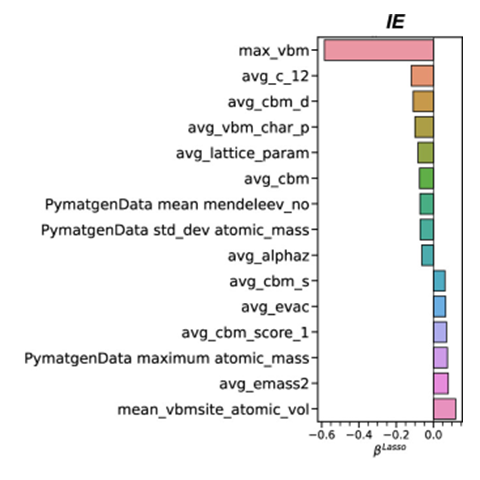

In [11]:
Image(filename='../docs/figs/lasso_coefs_diagram.png')

**LASSO Feature Selection**

Since the descriptor space is normalized, the magnitudes of the LASSO coefficients can be used to assess the “importance” of the descriptors relative to the other descriptors. The top 15 descriptors for the IE SEM model and their LASSO coefficients are displayed above. The maximum VBM of the two monolayers is a strong predictor of the bilayer IE.


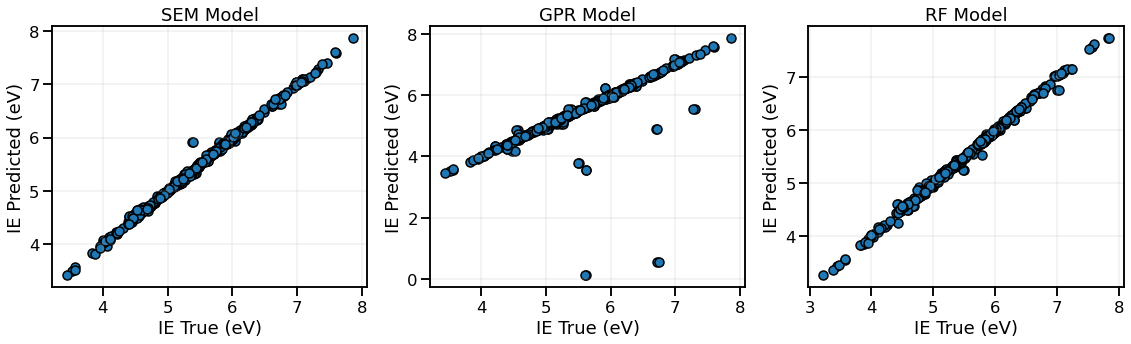

In [12]:
# plot pairity plots of true vs predicted for each model

sb.set_context('talk')
fig, axes = plt.subplots(1,3, figsize=plotters.fs()*[3,1]) 

ax = axes[0]
out = res['SEM']['parity_plot']
ax.scatter(out[:,0], out[:,1], ec='k')
plotters.myax(ax, 'IE True (eV)', 'IE Predicted (eV)')
ax.set_title('SEM Model')

ax = axes[1]
out = res['GPR']['parity_plot']
ax.scatter(out[:,0], out[:,1], ec='k')
plotters.myax(ax, 'IE True (eV)', 'IE Predicted (eV)')
ax.set_title('GPR Model')

ax = axes[2]
out = res['RF']['parity_plot']
ax.scatter(out[:,0], out[:,1], ec='k')
plotters.myax(ax, 'IE True (eV)', 'IE Predicted (eV)')
ax.set_title('RF Model')

plt.show() 


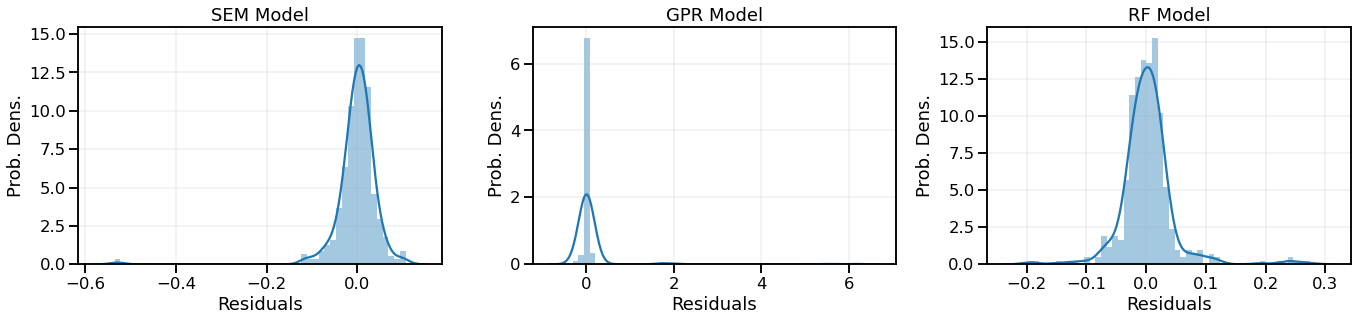

In [17]:
## plot residual distribution
warnings.simplefilter('ignore', category=FutureWarning)
def get_residuals(ytrue, ypred): 
    return ytrue - ypred

sb.set_context('talk')
fig, axes = plt.subplots(1,3, figsize=plotters.fs()*[3,1]) 

ax = axes[0]
out = res['SEM']['parity_plot']
sb.distplot(get_residuals(out[:,0], out[:,1]), ax=ax)
plotters.myax(ax, 'Residuals', 'Prob. Dens.')
ax.set_title('SEM Model')

ax = axes[1]
out = res['GPR']['parity_plot']
sb.distplot(get_residuals(out[:,0], out[:,1]), ax=ax)
plotters.myax(ax, 'Residuals', 'Prob. Dens.')
ax.set_title('GPR Model')

ax = axes[2]
out = res['RF']['parity_plot']
sb.distplot(get_residuals(out[:,0], out[:,1]), ax=ax)
plotters.myax(ax, 'Residuals', 'Prob. Dens.')
ax.set_title('RF Model')

fig.tight_layout() 
plt.show() 


**True vs Predicted**

Here the ML predicted values are compared with the DFT labeled values. All three models are highly accurate. The GPR has a few significant underestimates for 6-7 materials. Since the GPR and RF model are able to determine the uncertainty easily, I will use both in an active learning approach. 

In the [next Notebook](./03-active_learning_for_DFT_surrogate.ipynb) I will demonstrate how active learning can be build a ML model with fewer data points using Active Learning. 
